In [1513]:
import numpy as np
import pandas as pd
import stockstats as st
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [1514]:
data = st.StockDataFrame.retype(pd.read_csv('/home/anupam/stockPrediction/data/^BSESN (5).csv'))

In [1515]:
data.index = pd.to_datetime(data.index)
data.interpolate(method='time',inplace=True)
#data.dropna(inplace=True)

In [1516]:
data.shape

(5297, 6)

In [1517]:
SMA5 = data['adj close'].rolling(window=5).mean()
SMA10 = data['adj close'].rolling(window=10).mean()
SMA20 = data['adj close'].rolling(window=20).mean()
data = pd.concat([data,SMA5,SMA10,SMA20],axis=1,sort=False)
data.columns.values[6] = 'sma5'
data.columns.values[7] = 'sma10'
data.columns.values[8] = 'sma20'

In [1518]:
prev = 0
i = 1
def calc(diff,volume):
    "part of on balance volume"
    global i
    global prev
    if i == 1:
        i = 0
        prev = volume
        return volume
    elif diff > 0:
        value = prev = prev + volume
        return value
    elif diff < 0:
        value = prev = prev - volume
        return value
    elif diff == 0:
        value = prev
        return value

def OBV(data):
    "function to calculate on balance volume"
    data['prior close'] = data['adj close'].shift(1)
    data['diff'] = data['adj close'] - data['prior close']
    temp = [calc(x,y) for x,y in zip(data['diff'].values[1:],data['volume'].values[1:])]
    temp = temp + [0]
    temp = np.array(temp)
    data['obv'] = temp
    data['obv'] = data['obv'].shift(1)
    data.drop(['prior close','diff'],axis=1,inplace=True)
    return data

data = OBV(data)

In [1519]:
data['macd']  #to calculate moving avrage convergence divergence
data['rsi_10']#to calculate relative strength index for 10 dsys
data['rsi_20']#to calculate relative strength index for 20 days
data['cci_20']#to calculate commodity channel index for 20 days
data['atr']   #to calculate average true range for 14 days
data['wr_14'] #to calculate williams%R for 14 days
data['kdjk']  #a stochastic oscillator
data['kdjd']  #a stochastic oscillator(here a is used so that cell doesn't display the series)
a = data['trix'] # to calculate triple exponentially smoothed moving average

/home/anupam/anaconda3/lib/python3.6/site-packages/stockstats.py:387: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: np.fabs(x - x.mean()).mean())


In [1520]:
featureList = ['open', 'high', 'low', 'adj close','volume','sma5','sma10','sma20','macd','rsi_10', 'rsi_20','cci_20','atr','wr_14','kdjk','kdjd','obv','trix']
data1 = data[featureList]

In [1521]:
data1.dropna(inplace=True)

In [1522]:
data1.head()

,open,high,low,adj close,volume,sma5,sma10,sma20,macd,rsi_10,rsi_20,cci_20,atr,wr_14,kdjk,kdjd,obv,trix
date,,,,,,,,,,,,,,,,,,
1997-07-28,4191.910156,4197.209961,4163.529785,4181.479980,0.0,4207.016016,4191.221973,4256.107983,-19.481515,40.395266,40.601214,-74.327668,69.548249,77.769959,41.588624,36.396150,0.0,-0.140283
1997-07-29,4180.589844,4218.979980,4171.109863,4217.580078,0.0,4213.274023,4190.877979,4251.943994,-17.387126,47.284883,45.228692,-48.896648,67.544715,67.238403,47.461791,40.084697,0.0,-0.135898
1997-07-30,4230.799805,4253.810059,4220.180176,4244.890137,0.0,4212.026074,4197.025000,4247.493506,-13.726597,51.953105,48.428107,-9.284949,64.710057,47.803402,56.176799,45.448731,0.0,-0.126530
1997-07-31,4252.370117,4331.580078,4245.520020,4305.759766,0.0,4227.904004,4208.239990,4246.608496,-6.589593,60.594903,54.644038,51.660545,66.662433,11.409756,66.981281,52.626248,0.0,-0.108856
1997-08-01,4322.189941,4356.549805,4314.060059,4347.319824,0.0,4259.405957,4230.490967,4247.783496,1.888463,65.326134,58.259798,97.933235,65.276666,3.673332,76.528696,60.593730,0.0,-0.083330


In [1523]:
data1.shape

(5278, 18)

In [1524]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
data1Scaled = pd.DataFrame(scaler.fit_transform(data1),columns=featureList)

In [1525]:
data1Scaled.head()

,open,high,low,adj close,volume,sma5,sma10,sma20,macd,rsi_10,rsi_20,cci_20,atr,wr_14,kdjk,kdjd,obv,trix
0,-1.014864,-1.020024,-1.011279,-1.015532,-0.784518,-1.012552,-1.013861,-1.006246,-0.281288,-0.868765,-1.149917,-0.852430,-1.104085,1.110774,-0.579423,-0.886356,-1.353404,-0.648421
1,-1.016061,-1.017729,-1.010473,-1.011710,-0.784518,-1.011889,-1.013897,-1.006689,-0.271564,-0.426403,-0.735806,-0.621936,-1.118914,0.779580,-0.348179,-0.722127,-1.353404,-0.632682
2,-1.010750,-1.014059,-1.005256,-1.008819,-0.784518,-1.012021,-1.013245,-1.007162,-0.254568,-0.126671,-0.449492,-0.262917,-1.139894,0.168392,-0.005044,-0.483298,-1.353404,-0.599054
3,-1.008469,-1.005863,-1.002562,-1.002374,-0.784518,-1.010339,-1.012055,-1.007256,-0.221431,0.428193,0.106769,0.289461,-1.125444,-0.976107,0.420359,-0.163726,-1.353404,-0.535614
4,-1.001084,-1.003231,-0.995275,-0.997974,-0.784518,-1.007000,-1.009694,-1.007131,-0.182068,0.731971,0.430342,0.708852,-1.135700,-1.219401,0.796268,0.191019,-1.353404,-0.443987


In [1526]:
data1Scaled['Label'] = np.array(data1['adj close'].shift(-30).values)

In [1527]:
data1Scaled.tail(20)

,open,high,low,adj close,volume,sma5,sma10,sma20,macd,rsi_10,rsi_20,cci_20,atr,wr_14,kdjk,kdjd,obv,trix,Label
5258,2.296965,2.284739,2.265376,2.248576,0.982883,2.259554,2.246121,2.271961,0.330984,-0.189827,-0.001866,-0.011548,0.946674,0.029985,0.359884,0.094276,1.176300,-0.037732,NaN
5259,2.246851,2.233893,2.244370,2.237069,-0.285558,2.258579,2.248794,2.270296,0.248436,-0.380465,-0.145953,-0.555691,0.915911,0.302814,0.092537,0.097753,1.171489,-0.046343,NaN
5260,2.236596,2.250483,2.256245,2.266255,-0.177349,2.264360,2.257643,2.269549,0.280857,0.090378,0.175126,-0.135230,0.911518,-0.389223,0.056953,0.086658,1.177344,-0.048278,NaN
5261,2.273181,2.292422,2.296861,2.296344,-0.255500,2.267342,2.266130,2.270702,0.406145,0.489234,0.473504,0.633264,0.968469,-0.942508,0.368438,0.196674,1.182445,-0.035769,NaN
5262,2.286729,2.277294,2.294907,2.294290,-0.189373,2.271929,2.271635,2.270213,0.490314,0.447972,0.445403,0.514910,0.902579,-0.896470,0.547585,0.337546,1.176706,-0.016446,NaN
5263,2.293723,2.300468,2.314521,2.298503,-0.117234,2.281924,2.275009,2.269823,0.563235,0.506309,0.487843,0.848480,0.860547,-0.838351,0.638921,0.465889,1.183140,0.006779,NaN
5264,2.299298,2.304498,2.318198,2.320636,-0.117234,2.298653,2.282895,2.270613,0.689202,0.799168,0.706069,1.071949,0.823018,-1.219307,0.930179,0.661239,1.189575,0.038130,NaN
5265,2.332102,2.318655,2.343384,2.325574,-0.069141,2.310528,2.291734,2.272481,0.795140,0.861257,0.753616,1.249238,0.746345,-0.965500,1.027540,0.828173,1.196473,0.073449,NaN
5266,2.322335,2.305215,2.319206,2.310821,-0.195384,2.313427,2.294677,2.274878,0.815296,0.484494,0.524225,0.799452,0.715557,-0.570708,0.925093,0.900845,1.190792,0.102884,NaN
5267,2.313150,2.297344,2.311884,2.313185,-0.243477,2.317209,2.298867,2.278993,0.827888,0.522275,0.549487,0.624549,0.683897,-0.632156,0.883603,0.933653,1.196009,0.126784,NaN


In [1528]:
data1Scaled.shape

(5278, 19)

In [1529]:
data2Scaled = data1Scaled.dropna(inplace=False)

In [1530]:
data2Scaled.tail(10)

,open,high,low,adj close,volume,sma5,sma10,sma20,macd,rsi_10,rsi_20,cci_20,atr,wr_14,kdjk,kdjd,obv,trix,Label
5238,2.242001,2.253568,2.264896,2.269353,-0.027060,2.262661,2.242396,2.213504,1.547971,1.150015,0.974013,0.868947,0.635544,-0.919246,0.882105,1.111195,1.185865,0.520918,35548.261719
5239,2.280741,2.267169,2.281724,2.270219,0.069125,2.263847,2.250519,2.221097,1.568228,1.160482,0.982042,0.891241,0.608193,-0.854542,0.932398,1.092280,1.194097,0.528701,35286.738281
5240,2.264687,2.268851,2.281531,2.281127,-0.219430,2.266876,2.257974,2.228750,1.602214,1.295211,1.084792,0.823845,0.592191,-1.100269,1.070309,1.131654,1.199546,0.534949,35547.328125
5241,2.281175,2.278961,2.288937,2.273390,-0.279546,2.269910,2.265879,2.235694,1.581339,1.029879,0.946710,0.755239,0.591224,-0.690274,0.845222,1.073059,1.194676,0.534518,35432.390625
5242,2.274197,2.289014,2.295125,2.304042,-0.249488,2.283059,2.274602,2.243323,1.652020,1.409965,1.234347,0.869630,0.618330,-1.192934,1.031118,1.104068,1.199835,0.538587,35689.601563
5243,2.302527,2.293921,2.315805,2.306257,-0.243477,2.290447,2.280830,2.250577,1.694145,1.434086,1.254137,0.898447,0.556948,-1.117173,1.118912,1.157834,1.205053,0.543324,35470.351563
5244,2.300626,2.330892,2.320202,2.304905,-0.063130,2.297391,2.284900,2.257163,1.700939,1.382894,1.228063,1.001733,0.663543,-0.447358,0.804491,1.075158,1.198096,0.545081,35490.039063
5245,2.291582,2.283506,2.292953,2.288383,-0.129257,2.298843,2.287144,2.262442,1.626900,0.780526,0.911653,0.487119,0.660336,-0.054840,0.416138,0.873654,1.191778,0.536421,35217.109375
5246,2.294890,2.279936,2.276600,2.263105,-0.123245,2.296784,2.287632,2.266789,1.459746,0.040302,0.466646,0.203923,0.720733,0.791507,-0.240106,0.491951,1.185401,0.510471,35037.640625
5247,2.258924,2.243377,2.248298,2.231256,-0.213419,2.282213,2.286920,2.269028,1.198558,-0.647252,-0.026337,-0.417412,0.734152,1.738265,-0.869153,0.000366,1.179894,0.462003,35423.480469


In [1531]:
data2Scaled.shape

(5248, 19)

In [1532]:
l = data2Scaled.corr()['Label']
print(l)

open         0.993700
high         0.993780
low          0.993799
adj close    0.993850
volume       0.188201
sma5         0.993643
sma10        0.993348
sma20        0.992750
macd         0.176488
rsi_10       0.085361
rsi_20       0.121934
cci_20       0.064299
atr          0.660651
wr_14       -0.067149
kdjk         0.068454
kdjd         0.077972
obv          0.918203
trix         0.062034
Label        1.000000
Name: Label, dtype: float64


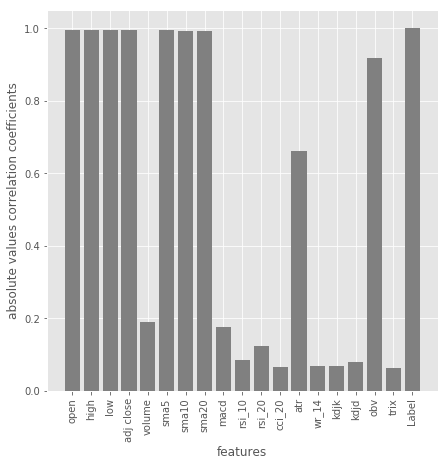

In [1533]:
plt.figure(figsize=(7,7))
plt.bar(data2Scaled.columns.values,abs(data2Scaled.corr()['Label'].values),color='gray')
plt.xlabel('features')
plt.xticks(rotation=90)
plt.ylabel('absolute values correlation coefficients')
plt.show()

In [1534]:
list = [column for column in l.index.values if 0.5<abs(l[column])<1]

In [1535]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data2Scaled[list])
pcaData = pca.transform(data2Scaled[list])

In [1536]:
components = ['PC' + str(x) for x in range(1,len(pca.explained_variance_)+1)]
varianceTable = pd.DataFrame({'Variance':pca.explained_variance_,'Variance %': pca.explained_variance_ratio_*100},index=components)

In [1537]:
varianceTable

,Variance,Variance %
PC1,8.200390,92.834567
PC2,0.530602,6.006811
PC3,0.099827,1.130117
PC4,0.001996,0.022594
PC5,0.000273,0.003086
PC6,0.000136,0.001540
PC7,0.000052,0.000583
PC8,0.000050,0.000563
PC9,0.000012,0.000139


In [1538]:
selectedComponents = [x for x,y in zip(range(len(pca.explained_variance_)),pca.explained_variance_) if y>=0.1]

In [1539]:
componentTable = pd.DataFrame(index=list)
for x in selectedComponents:
    componentTable['PC' + str(x+1)] = pd.Series(pca.components_[x],index=list)

In [1540]:
componentTable

,PC1,PC2
open,0.343313,-0.127398
high,0.343459,-0.121993
low,0.343103,-0.134967
adj close,0.343287,-0.128181
sma5,0.343344,-0.125977
sma10,0.343370,-0.121303
sma20,0.343388,-0.111237
atr,0.256672,0.925525
obv,0.330187,0.186241


In [1541]:
pcaData = pd.DataFrame(data=pcaData) 

In [1542]:
X = np.array(pcaData[selectedComponents])
y = np.array(data2Scaled['Label'])
XCheck = X[-30:]
X = X[:-30]
yCheck = y[-30:]
y = y[:-30]

In [1543]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LinearRegression

In [1544]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False)
svr_rbf = svm.SVR(C=10000,gamma=0.001,epsilon=0.01)
# model = LinearRegression()
svr_rbf.fit(X_train,y_train)
print(svr_rbf)
r2rbf = svr_rbf.score(X_test,y_test)
print("R-squared = {}".format(r2rbf))

SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R-squared = 0.7873925579784046


In [1545]:
svr_poly = svm.SVR(C=10000,gamma=0.01,epsilon=0.0001,kernel='poly',degree=3)
# model = LinearRegression()
svr_poly.fit(X_train,y_train)
print(svr_poly)
r2poly = svr_poly.score(X_test,y_test)
print("R-squared = {}".format(r2poly))

SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001, gamma=0.01,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R-squared = -2.24843263573414


In [1546]:
svr_sigmoid = svm.SVR(C=10000,gamma=0.01,epsilon=0.1,kernel='sigmoid')
# model = LinearRegression()
svr_sigmoid.fit(X_train,y_train)
print(svr_sigmoid)
r2sigmoid = svr_sigmoid.score(X_test,y_test)
print("R-squared = {}".format(r2sigmoid))

SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R-squared = 0.8930614663102664


In [1547]:
svr_linear = svm.SVR(C=1000,epsilon=0.1,kernel='linear')
# model = LinearRegression()
svr_linear.fit(X_train,y_train)
print(svr_linear)
r2linear = svr_linear.score(X_test,y_test)
print("R-squared = {}".format(r2linear))

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R-squared = 0.9074703755912287


In [1548]:
predict = svr_linear.predict(XCheck)

In [1549]:
df = pd.DataFrame(data=data1['adj close'][-30:])
df['Forecasted close'] = predict
df

,adj close,Forecasted close
date,,
2018-05-21,34616.128906,32478.678194
2018-05-22,34651.238281,32589.776112
2018-05-23,34344.910156,32732.297276
2018-05-24,34663.109375,32798.071128
2018-05-25,34924.871094,32907.219786
2018-05-28,35165.480469,33030.848324
2018-05-29,34949.238281,33020.367137
2018-05-30,34906.109375,33194.584467
2018-05-31,35322.378906,33253.288970


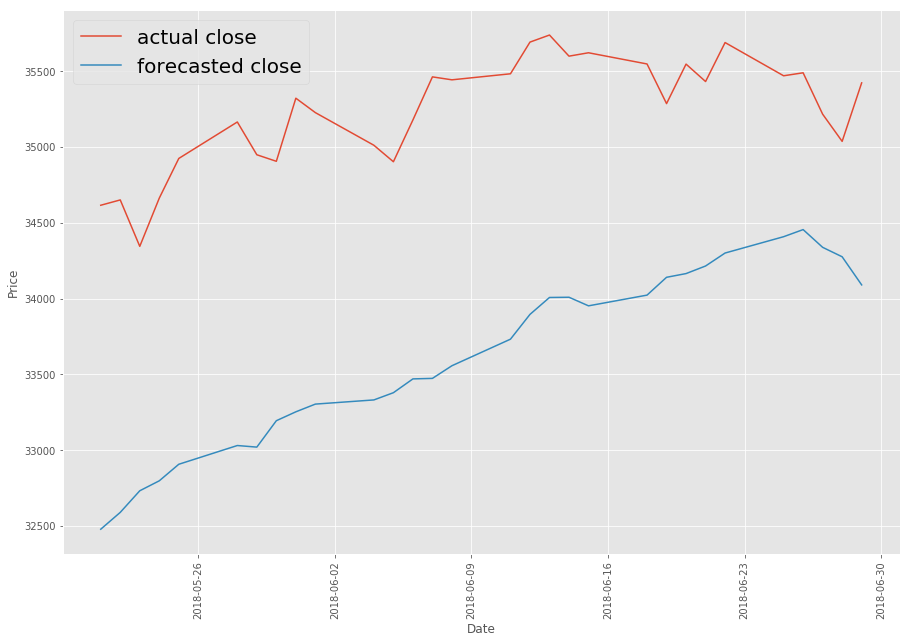

In [1550]:
plt.figure(figsize=(15,10))
plt.plot(df['adj close'],label='actual close')
plt.plot(df['Forecasted close'],label='forecasted close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.legend(fontsize=20)
plt.show()